# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas
import pandas as pd
import numpy as np

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:

sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# Your code here:
sensor.isnull().sum()


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [6]:
# Your code here:

print(f'hay {sensor.shape[0]} filas y {sensor.shape[1]} columnas en el df')

hay 1751 filas y 12 columnas en el df


In [13]:
python -V

NameError: name 'python' is not defined

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [18]:
# Your code here:
time= pd.date_range(start='1/1/2018 00:00:00',end='1/1/2018 00:29:10', freq= 's')
len(time)

1751

Assign the time series index to the dataframe's index.

In [20]:
# Your code here:
sensor.set_index(time, inplace=True)


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [27]:
# Your code here:
import statsmodels.api as sm
import matplotlib as plt

C:\Users\fezun\AppData\Local\Temp/ipykernel_25256/3340813724.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomp_serie = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60)


''

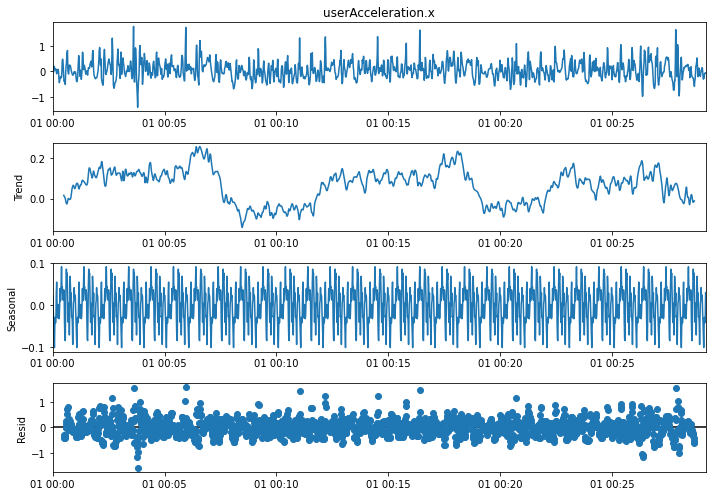

In [34]:
descomp_serie = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60)
descomp_serie.plot()
;

#No entiendo porqué la última gráfica no se parece

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

C:\Users\fezun\AppData\Local\Temp/ipykernel_25256/4247976395.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomp_serie = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60)


''

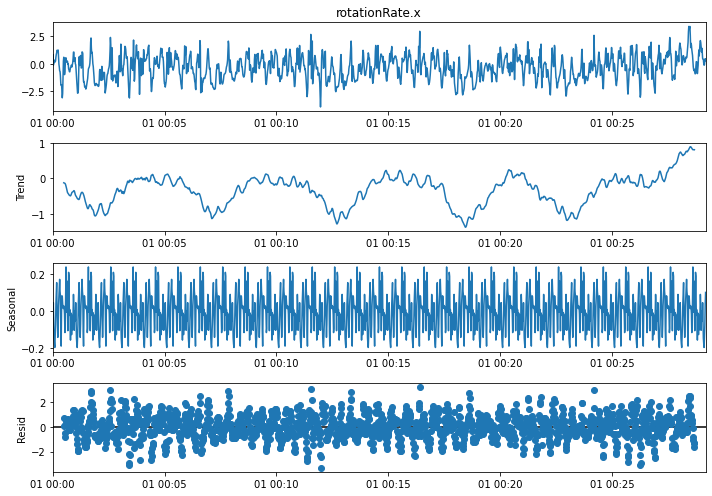

In [33]:
descomp_serie = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60)
descomp_serie.plot()
;

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

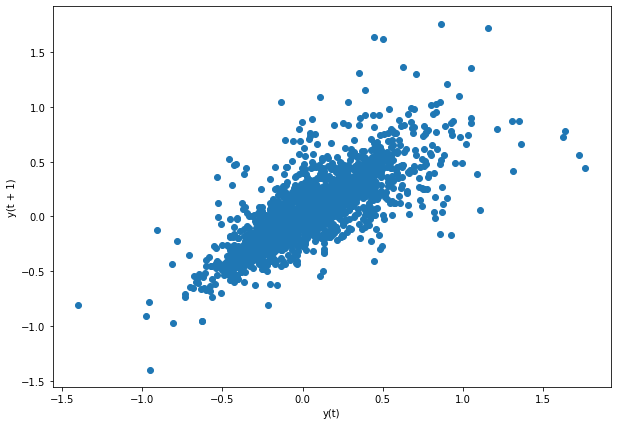

In [38]:
# Your code here:

pd.plotting.lag_plot(sensor['userAcceleration.x'])


Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

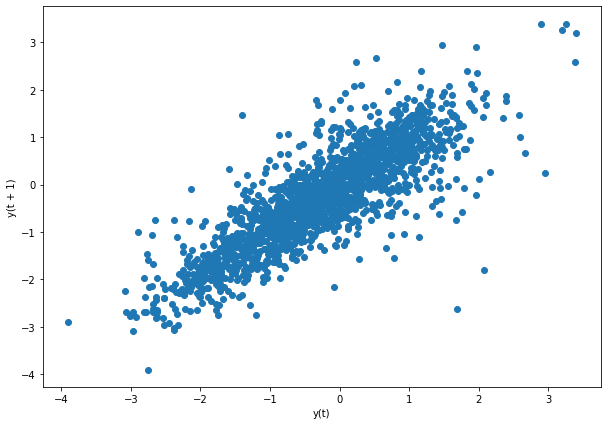

In [39]:
# Your code here:

pd.plotting.lag_plot(sensor['rotationRate.x'])

What are your conclusions from both visualizations?

In [40]:
# Your conclusions here:
#Existe una autocorrelación en las variables estudiadas


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [43]:
# Your code here:
from statsmodels.tsa.stattools import adfuller
print(f'userAcceleration.x: {adfuller(sensor["userAcceleration.x"])[1]}\nrotationRate.x: {adfuller(sensor["rotationRate.x"])[1]}')


userAcceleration.x: 2.823439483037563e-30
rotationRate.x: 6.320230335912189e-06


What are your conclusions from this test?

In [45]:
# Your conclusions here:
#Dado que los valores de p-value son cero, podemos rechazar la h0 y concluir que la data es estacionaria


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [73]:
# Your code here:
from statsmodels.tsa.arima_model import ARMA
sensor.shape

(1751, 12)

In [74]:
train=sensor.iloc[0:1740]['userAcceleration.x']
test=sensor.iloc[1741:1751]['userAcceleration.x']

In [88]:
model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(len(test)-10, len(test)-0)

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [97]:
# Your code here:
from statsmodels.tools.eval_measures import rmse

rmse(sensor.loc['2018-01-01 00:00:00':'2018-01-01 00:00:10']['userAcceleration.x'], predictions)

0.10699845245726733

In [96]:
sensor.loc['2018-01-01 00:00:00':'2018-01-01 00:00:10']['userAcceleration.x']

2018-01-01 00:00:00    0.294894
2018-01-01 00:00:01    0.219405
2018-01-01 00:00:02    0.010714
2018-01-01 00:00:03   -0.008389
2018-01-01 00:00:04    0.199441
2018-01-01 00:00:05    0.168241
2018-01-01 00:00:06    0.079382
2018-01-01 00:00:07    0.069360
2018-01-01 00:00:08    0.072889
2018-01-01 00:00:09    0.098347
2018-01-01 00:00:10   -0.017600
Freq: S, Name: userAcceleration.x, dtype: float64

In [94]:
predictions

2018-01-01 00:00:00    0.063548
2018-01-01 00:00:01    0.239209
2018-01-01 00:00:02    0.127199
2018-01-01 00:00:03   -0.068771
2018-01-01 00:00:04    0.023499
2018-01-01 00:00:05    0.257185
2018-01-01 00:00:06    0.099294
2018-01-01 00:00:07    0.035916
2018-01-01 00:00:08    0.069402
2018-01-01 00:00:09    0.071213
2018-01-01 00:00:10    0.099349
Freq: S, dtype: float64